In [1]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from uk_covid19 import Cov19API

In [2]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [3]:
def access_api():

    filters = ['areaType=nation' ,
            'areaName=England']


    structure = { "date": "date",'admissions' : 'newAdmissions', 'occupied ventilator beds' : 'covidOccupiedMVBeds'}


    api = Cov19API(filters=filters, structure=structure)

    jsondata = api.get_json()
    return jsondata

In [4]:
with open("ventilator.json", "rt") as INFILE:
    jsondata=json.load(INFILE)

In [ ]:
# Data wrangling #

In [5]:
def wrangle_data(rawdata):
    def parse_date(datestring):
        return pd.to_datetime(datestring, format="%Y-%m-%d")
    datalist=jsondata['data']
    dates=[dictionary['date'] for dictionary in datalist ]
    dates.sort()
    startdate=parse_date(dates[0])
    enddate=parse_date(dates[-1])
    print (startdate, ' to ', enddate)
    index=pd.date_range(startdate, enddate, freq='D')
    timeseriesdf=pd.DataFrame(index=index, columns=['admissions' , 'occupied ventilator beds'])
    for entry in datalist: # each entry is a dictionary with date, cases, hospital and deaths
        date=parse_date(entry['date'])
        for column in ['admissions' , 'occupied ventilator beds']:
            if pd.isna(timeseriesdf.loc[date, column]): 
                value= float(entry[column]) if entry[column]!=None else 0.0
                timeseriesdf.loc[date, column]=value
    timeseriesdf.fillna(0.0, inplace=True)
    return(timeseriesdf)
            
print(wrangle_data(jsondata))

2020-03-19 00:00:00  to  2022-10-19 00:00:00
           admissions occupied ventilator beds
2020-03-19      586.0                      0.0
2020-03-20      691.0                      0.0
2020-03-21      777.0                      0.0
2020-03-22      859.0                      0.0
2020-03-23     1128.0                      0.0
...               ...                      ...
2022-10-15      900.0                    221.0
2022-10-16     1206.0                    217.0
2022-10-17     1121.0                    207.0
2022-10-18        0.0                    200.0
2022-10-19        0.0                    206.0

[945 rows x 2 columns]


In [ ]:
# Update button #

In [6]:
def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    # Get fresh data from the API. If you have time, include some error handling
    # around this call.
    apidata=access_api()
    # wrangle the data and overwrite the dataframe for plotting
    global df
    df=wrangle_data(apidata)
    # the graph won't refresh until the user interacts with the widget.
    # this function simulates the interaction, see Graph and Analysis below.
    # you can omit this step in the first instance
    refresh_graph()
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again. You can use icons
    # "unlink" or "times" and change the button text to "Unavailable" in case the 
    # api call fails.
    apibutton.icon="check"
    # apibutton.disabled=True

    
apibutton=wdg.Button(
    description="Update Dataset", # you may want to change this...
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Keep calm and carry on",
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='download'
)

# remember to register your button callback function with the button
apibutton.on_click(api_button_callback) # the name of your function inside these brackets

display(apibutton)

# run all cells before clicking on this button

Button(button_style='success', description='Update Dataset', icon='download', style=ButtonStyle(), tooltip='Ke…

In [ ]:
# Graph plot

2020-03-19 00:00:00  to  2022-10-19 00:00:00


<AxesSubplot: >

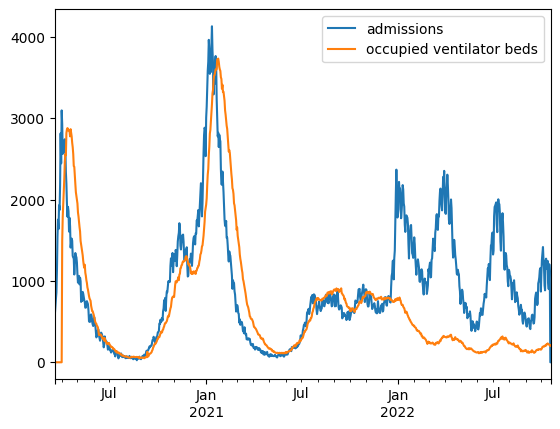

In [7]:
wrangle_data(jsondata).plot()

In [10]:
wrangle_data(jsondata).to_pickle("timeseriesdf.pkl")
timeseriesdf=pd.read_pickle("timeseriesdf.pkl")
series=wdg.SelectMultiple(
    options=['admissions' , 'occupied ventilator beds'],
    value=['admissions' , 'occupied ventilator beds'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

# try replacing HBox with a VBox
controls=wdg.HBox([series, scale])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        timeseriesdf[list(gcols)].plot(logy=logscale)
        plt.show() # important - graphs won't update if this is missing 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

# keep calling timeseries_graph(gcols=value_of_series, gscale=value_of_scale); 
# capture output in widget graph   
graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

2020-03-19 00:00:00  to  2022-10-19 00:00:00


Output()